Jigsaw Unintended Bias in Toxicity Classification

In [0]:
SETUP = True

In [0]:
if SETUP:
    !pip install -q -U toai
    !pip install -q -U nb_black
    !pip install -q -U tensorflow-datasets
    !pip install -q -U --no-deps tensorflow-addons~=0.6
    !pip install dovpanda
    !pip install tensorflow==2.0.0-rc0 

    !pip install -q kaggle

    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    
    print(__import__("toai").__version__)
    print(__import__("tensorflow").__version__)

In [2]:
from toai.imports import *
from toai.data import DataBundle, DataParams, DataContainer
from toai.metrics import sparse_top_2_categorical_accuracy
import tensorflow as tf
from tensorflow import keras
#import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import dovpanda 
from toai.utils import download_file, unzip, save_file, load_file


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
import matplotlib.pyplot as plt

In [0]:
BATCH_SIZE = 16

In [0]:
dovpanda.tip()

In [0]:
DATA_DIR = Path("data/NLP-Jigsaw")
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR = Path("temp/NLP-Jigsaw")
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [7]:
 kaggle.api.competition_download_file(
     competition="jigsaw-unintended-bias-in-toxicity-classification",
     file_name="train.csv",
     path=DATA_DIR,
 )

  0%|          | 0.00/273M [00:00<?, ?B/s]

100%|██████████| 273M/273M [00:05<00:00, 40.5MB/s]

In [0]:
unzip.all_files_in_dir(DATA_DIR, ".zip")

===== File size is very large and may take time to load. If you would like to avoid format issues before the complete file loads, try:  pd.read_csv(data/NLP-Jigsaw/train.csv, nrows=5) to check schema is as expected. ===== (Line 1)
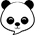

===== Dataframe has 5 rows. Column rating has only 1 values which suggests it's a categorical feature.
After df is created, Consider converting it to categorical by using df['rating'] = df['rating'].astype('category') ===== (Line 1)
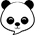

===== columns 'created_date' looks like a datetime but the type is 'object' Consider using
df['created_date'] = pd.to_datetime(df.created_date) ===== (Line 1)
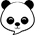

In [6]:
train_df = pd.read_csv(DATA_DIR/'train.csv',)

In [76]:
train_df.head(10)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,target1,binary_target
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4,0,0
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4,0,0
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4,0,0
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4,0,0
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.000000,4,47,1,1
5,59859,0.666667,ur a sh*tty comment.,0.047619,0.638095,0.000000,0.333333,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:50.865549+00,2,NaN,2006,rejected,0,0,0,0,0,0.009524,0,105,1,1
6,59861,0.457627,hahahahahahahahhha suck it.,0.050847,0.305085,0.000000,0.254237,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:52.451277+00,2,NaN,2006,rejected,0,0,0,0,0,0.220339,0,59,1,1
7,59863,0.000000,FFFFUUUUUUUUUUUUUUU,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:54.055221+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4,0,0
8,239575,0.000000,The ranchers seem motivated by mostly by greed...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-13 18:01:05.156229+00,6,NaN,26662,approved,0,0,0,0,0,0.000000,0,4,0,0
9,239576,0.000000,It was a great show. Not a combo I'd of expect...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-13 18:11:21.570460+00,6,239522.0,26650,approved,0,0,0,1,0,0.000000,0,4,0,0


In [0]:
plt.figure(figsize=(12,6))
sns.distplot(train_df['target'])
plt.show()

In [0]:
pd.value_counts(train_df['binary_target']).plot.bar()
plt.show()

In [0]:
sns.pairplot(train_df,hue='target')

In [0]:
train_df.describe().T

In [19]:
train_df['target'].value_counts()

0.000000    1264764
0.166667     138501
0.200000     107492
0.300000      59098
0.400000      50013
             ...   
0.813022          1
0.967863          1
0.897840          1
0.945655          1
0.872187          1
Name: target, Length: 2913, dtype: int64

In [0]:
train_df['binary_target'] = (train_df['target'] > 0.15).astype(int)

In [11]:
train_df['binary_target'].value_counts()

0    1287296
1     517578
Name: binary_target, dtype: int64

In [0]:
pd.value_counts(train_df['binary_target']).plot.bar()
plt.show()

In [63]:
train_df[["target", "binary_target"]].tail(10)

,target,binary_target
1804864,0.000000,0
1804865,0.166667,1
1804866,0.300000,1
1804867,0.200000,1
1804868,0.000000,0
1804869,0.000000,0
1804870,0.000000,0
1804871,0.000000,0
1804872,0.621212,1
1804873,0.000000,0


In [0]:
import matplotlib.pyplot as plt


In [0]:
def make_category_map(labels):
    return {x: i for i, x in enumerate(sorted(set(labels)))}  #set(labels) converts to array

In [0]:
category_map = make_category_map(train_df["binary_target"].values)

In [15]:
len(category_map)

2

In [16]:
category_map

{0: 0, 1: 1}

In [0]:
n_categories = len(category_map)

In [0]:
data_container = DataContainer(
    *DataBundle.split(
        data_bundle=DataBundle.from_dataframe(
            dataframe=train_df, x_col="comment_text", y_col="binary_target"
        ),
        fracs=[0.02, 0.01, 0.01],
    )
)

In [0]:
data_container = DataContainer(
    *DataBundle.split(
        data_bundle=DataBundle.from_dataframe(
            dataframe=train_df, x_col="comment_text", y_col="target"
        ),
        fracs=[0.02, 0.01, 0.01],
    )
)

In [0]:
class_weights = dict(
    enumerate(
        sk.utils.class_weight.compute_class_weight(
            "balanced", np.unique(data_container.train.y), data_container.train.y
        )
    )
)

In [90]:
class_weights

{0: 0.7013133354056574, 1: 1.7418452036286431}

In [21]:
len(data_container.train), len(data_container.validation), len(data_container.test)

(36098, 18049, 18049)

In [62]:
len(data_container_reg.train), len(data_container_reg.validation), len(data_container_reg.test)

(36098, 18049, 18049)

In [0]:
def make_dataset(data_bundle):
    return tf.data.Dataset.from_tensor_slices((data_bundle.x, data_bundle.y))

In [0]:
data_container.train.dataset = make_dataset(data_container.train)
data_container.validation.dataset = make_dataset(data_container.validation)
data_container.test.dataset = make_dataset(data_container.test)

In [25]:
data_container.train.x[95],data_container.train.y[95]


('When had NK threatend us? Where have you been?', 1)

In [0]:
def preprocess(x, y, max_length=100):
    x = tf.strings.regex_replace(x, rb"<br\s*/>", b" ")
    x = tf.strings.regex_replace(x, b"[^a-zA-Z']", b" ")
    x = tf.strings.split(x) #split space
    x = x[:, :max_length]
    return x.to_tensor(default_value=b"<pad>"), y #convert to regural tensor from ragged

In [10]:
for x, y in data_container.train.dataset.batch(BATCH_SIZE).map(preprocess).take(1):
    print(x.shape)
    print(y.shape)
    print(x[0])
    print(y[0])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(16, 100)
(16,)
tf.Tensor(
[b'Joe' b'you' b'need' b'to' b'stop' b'making' b'up' b'stories' b'about'
 b'Hillary' b'You' b'know' b'that' b'you' b'were' b'never' b'even'
 b'considered' b'a' b'candidate' b'for' b'it' b'was' b'always' b'Hillary'
 b'since' b'she' b'had' b'to' b'wait' b'eight' b'years' b'for' b'Barack'
 b'You' b'will' b'never' b'be' b'the' b'president' b'of' b'America' b'Joe'
 b'you' b"aren't" b'really' b'an' b'American' b'only' b'in' b'your'
 b'mind' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>'], 

In [0]:
def make_vocabulary(dataset):
    vocabulary = Counter()
    for x, _ in dataset.batch(BATCH_SIZE).map(preprocess):
        for review in x:
            vocabulary.update(review.numpy().tolist())
    return vocabulary

In [0]:
VOCABULARY_SIZE = 10000

In [0]:
vocabulary = make_vocabulary(data_container.train.dataset)

In [32]:
vocabulary.most_common()[:20]

[(b'<pad>', 1960236),
 (b'the', 74365),
 (b'to', 45579),
 (b'and', 36937),
 (b'of', 34623),
 (b'a', 33206),
 (b'is', 26219),
 (b'in', 22709),
 (b'that', 21299),
 (b'I', 16016),
 (b'for', 15957),
 (b'you', 14103),
 (b'it', 13231),
 (b'are', 12817),
 (b'not', 11266),
 (b'be', 11088),
 (b'on', 10528),
 (b'have', 10458),
 (b'with', 9967),
 (b'The', 8182)]

In [33]:
len(vocabulary)

60009

In [0]:
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:VOCABULARY_SIZE]
]

In [35]:
len(truncated_vocabulary)

10000

In [0]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}

In [37]:
for word in b"I hate democrats because they are losers and asdasfasdas".split():
    print(word_to_id.get(word) or VOCABULARY_SIZE)

9
432
1940
79
20
13
3434
3
10000


In [99]:
words = tf.constant(truncated_vocabulary) # convert to tensor 
words

<tf.Tensor: id=550458, shape=(10000,), dtype=string, numpy=
array([b'<pad>', b'the', b'to', ..., b'isis', b'Polynesian', b'Hawai'],
      dtype=object)>

In [17]:
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
print(word_ids)

tf.Tensor([   0    1    2 ... 9997 9998 9999], shape=(10000,), dtype=int64)


In [0]:
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)


In [0]:
n_oov_buckets = 1000

In [0]:
table = tf.lookup.StaticVocabularyTable(vocab_init, n_oov_buckets)

In [43]:
table.lookup(tf.constant([b"I hate democrats because they are losers and asdasfasdas".split()]))

<tf.Tensor: id=149226, shape=(1, 9), dtype=int64, numpy=array([[    9,   432,  1940,    79,    20,    13,  3434,     3, 10344]])>

In [0]:
def encode_words(x, y):
    return table.lookup(x), y

In [0]:
def encode_categories(x, y):
    return table.lookup(x), y

In [0]:
train_dataset = (
    data_container.train.dataset.repeat()
    .batch(BATCH_SIZE)
    .map(preprocess)
    .map(encode_words)
    .prefetch(1)
)

In [0]:
validation_dataset = (
    data_container.validation.dataset.batch(BATCH_SIZE)
    .map(preprocess)
    .map(encode_words)
)

In [25]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x[3])
    print(y[3])

(16, 100)
(16,)
tf.Tensor(
[ 9248   482    13   645  2305  5626     3   330    38   388  1043 10622
    52    41  4252     2  1310   151    18  1645  5811 10809   335   857
    44   789     3    44  8292   300  2250   112    14    15   604   824
    66   212  4537    30    66  2280  3160     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(100,), dtype=int64)
tf.Tensor(0.2, shape=(), dtype=float64)


In [49]:
for x, y in validation_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x[3])
    print(y[3])
    
    # 0 = padding

(16, 100)
(16,)
tf.Tensor(
[ 7248    31  6997     4 10036  1275     7   511   293    54     6     5
  1882    30     1   511    13   445 10199   127   138 10738 10656  5078
    28     1   998     1  8633  1083    27 10990     2  7753   102     3
   844     1  3479     8   102  1090    63    26    33 10466    65    23
  6527     3  2643     2   498   320    20    13   288     2   222    51
     1   528    19   176   471     4   230     6     2   137   186     4
   371     3   222     5    89     2   700     1  1940  4078   399 10170
 10273    10  1158  3370   177   791    92    20   106  7753   198   479
    29     1  1158   103], shape=(100,), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)


In [0]:
train_dataset_steps = len(data_container.train) // BATCH_SIZE

In [0]:
validation_dataset_steps = len(data_container.validation) // BATCH_SIZE

RNN classification

In [0]:
def make_sequential_classification_lstm_model(
    n_categories, embedding_size, lstm_size, lstm_dropout, dropout
):
    return keras.models.Sequential(
        [
            keras.layers.Embedding(
                VOCABULARY_SIZE + n_oov_buckets,
                embedding_size,
                mask_zero=True,
                input_shape=[None],
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.GlobalMaxPool1D(),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(n_categories, activation=keras.activations.softmax),
        ]
    )

In [0]:
model = make_sequential_classification_lstm_model(
    n_categories=n_categories,
    embedding_size=16,
    lstm_size=16,
    lstm_dropout=0.2,
    dropout=0.1,
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        
    ],
)

In [58]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=5,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 2256 steps, validate for 1128 steps
Epoch 1/5
2256/2256 [==============================] - 332s 147ms/step - loss: 0.4697 - sparse_categorical_accuracy: 0.7881 - val_loss: 0.5045 - val_sparse_categorical_accuracy: 0.7721
Epoch 2/5
2256/2256 [==============================] - 323s 143ms/step - loss: 0.4013 - sparse_categorical_accuracy: 0.8267 - val_loss: 0.5026 - val_sparse_categorical_accuracy: 0.7727
Epoch 3/5
2256/2256 [==============================] - 321s 142ms/step - loss: 0.3586 - sparse_categorical_accuracy: 0.8503 - val_loss: 0.5142 - val_sparse_categorical_accuracy: 0.7681
Epoch 4/5
2256/2256 [==============================] - 333s 148ms/step - loss: 0.3240 - sparse_categorical_accuracy: 0.8679 - val_loss: 0.5391 - val_sparse_categorical_accuracy: 0.7581
Epoch 5/5
2256/2256 [==============================] - 392s 174ms/step - loss: 0.2681 - sparse_categorical_accuracy: 0.8951 - val_loss: 0.5933 - val_sparse_categorical_accuracy: 0.7511


In [59]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

1128/1128 [==============================] - 38s 34ms/step - loss: 0.5933 - sparse_categorical_accuracy: 0.7511


[0.5932573684233617, 0.75110817]

In [60]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.81      0.86      0.83     12904
           1       0.57      0.49      0.53      5145

    accuracy                           0.75     18049
   macro avg       0.69      0.67      0.68     18049
weighted avg       0.74      0.75      0.74     18049



RNN regression

In [0]:
def make_sequential_regression_lstm_model(
     embedding_size, lstm_size, lstm_dropout, dropout
):
    return keras.models.Sequential(
        [
            keras.layers.Embedding(
                VOCABULARY_SIZE + n_oov_buckets,
                embedding_size,
                mask_zero=True,
                input_shape=[None],
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.GlobalMaxPool1D(),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(1, activation=keras.activations.sigmoid),
        ]
    )

In [0]:
model = make_sequential_regression_lstm_model(
    embedding_size=16,
    lstm_size=16,
    lstm_dropout=0.2,
    dropout=0.1,
)

In [0]:
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=[
        keras.metrics.binary_accuracy,
        
    ],
)

In [51]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=5,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    
)

Train for 2256 steps, validate for 1128 steps
Epoch 1/5
2256/2256 [==============================] - 411s 182ms/step - loss: 0.3124 - binary_accuracy: 0.7002 - val_loss: 0.2903 - val_binary_accuracy: 0.6992
Epoch 2/5
2256/2256 [==============================] - 378s 168ms/step - loss: 0.2689 - binary_accuracy: 0.6992 - val_loss: 0.2749 - val_binary_accuracy: 0.6991
Epoch 3/5
2256/2256 [==============================] - 371s 165ms/step - loss: 0.2529 - binary_accuracy: 0.6997 - val_loss: 0.2727 - val_binary_accuracy: 0.6982
Epoch 4/5
2256/2256 [==============================] - 356s 158ms/step - loss: 0.2454 - binary_accuracy: 0.7004 - val_loss: 0.2739 - val_binary_accuracy: 0.6974
Epoch 5/5
2256/2256 [==============================] - 342s 151ms/step - loss: 0.2407 - binary_accuracy: 0.7004 - val_loss: 0.2749 - val_binary_accuracy: 0.6978


In [52]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

1128/1128 [==============================] - 33s 30ms/step - loss: 0.2749 - binary_accuracy: 0.6978


[0.2748548352384134, 0.6978058]

Conv1D +RNN

In [0]:
def make_conv1D_classification_lstm_model(
    n_categories, embedding_size, lstm_size, lstm_dropout, dropout,
):
    return keras.models.Sequential(
        [
            keras.layers.Embedding(
                VOCABULARY_SIZE + n_oov_buckets,
                embedding_size,
                mask_zero=True,
                input_shape=[None],
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.Conv1D(
              128,
              kernel_size=5,
              padding='same',
              activation=keras.activations.relu,
              kernel_initializer=keras.initializers.he_uniform(),
            ),
         
            keras.layers.GlobalMaxPool1D(),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(n_categories, activation=keras.activations.softmax),
        ]
    )

In [0]:
model = make_conv1D_classification_lstm_model(
    n_categories = n_categories,
    embedding_size=16,
    lstm_size=16,
    lstm_dropout=0.2,
    dropout=0.1,
    
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        
    ],
)

In [113]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=5,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    
)

Train for 2256 steps, validate for 1128 steps
Epoch 1/5


Exception ignored in: <bound method IteratorResourceDeleter.__del__ of <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter object at 0x7f091dce5a58>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 541, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/gen_dataset_ops.py", line 1157, in delete_iterator
    "DeleteIterator", handle=handle, deleter=deleter, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/op_def_library.py", line 793, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/func_graph.py", line 544, in create_op
    inp = self.capture(inp)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/while_v2.py", line 919, in capture
    (str(tensor), _graph_name(tensor.grap

2256/2256 [==============================] - 399s 177ms/step - loss: 0.5543 - sparse_categorical_accuracy: 0.7352 - val_loss: 0.5056 - val_sparse_categorical_accuracy: 0.7715
Epoch 2/5
2256/2256 [==============================] - 347s 154ms/step - loss: 0.4367 - sparse_categorical_accuracy: 0.8042 - val_loss: 0.4927 - val_sparse_categorical_accuracy: 0.7753
Epoch 3/5
2256/2256 [==============================] - 346s 153ms/step - loss: 0.3845 - sparse_categorical_accuracy: 0.8324 - val_loss: 0.5124 - val_sparse_categorical_accuracy: 0.7622
Epoch 4/5
2256/2256 [==============================] - 347s 154ms/step - loss: 0.3393 - sparse_categorical_accuracy: 0.8555 - val_loss: 0.5574 - val_sparse_categorical_accuracy: 0.7475
Epoch 5/5
2256/2256 [==============================] - 354s 157ms/step - loss: 0.2745 - sparse_categorical_accuracy: 0.8881 - val_loss: 0.6593 - val_sparse_categorical_accuracy: 0.7387


In [114]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

1128/1128 [==============================] - 36s 32ms/step - loss: 0.6593 - sparse_categorical_accuracy: 0.7387


[0.6593470400899437, 0.7386968]

In [115]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.81      0.82      0.82     12839
           1       0.55      0.54      0.54      5210

    accuracy                           0.74     18049
   macro avg       0.68      0.68      0.68     18049
weighted avg       0.74      0.74      0.74     18049

